In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla
df_nArticlesPerUser = pd.read_pickle("100_posts_data.pkl")

In [2]:
df_nArticlesPerUser

,ID_User,Beitrag
0,28526,Der öst. Arbeitslose wirkt irgendwie nachvollz...
1,28526,Wesentlicher und ehrlicher ist immer die absti...
2,28526,Eigentlich habe ich aber auch keine Lust mehr ...
3,28526,Bis zum 2. weltkrieg war Eugenik Mehrheitsmein...
4,28526,Ein Staatstreich ist per Definition ein Umstur...
...,...,...
1995,18006,Die politische Situation Ende der 1970er Jahre...
1996,18006,"Aber nein, China hat Apple Konditionen geboten..."
1997,18006,"Nein, der UN-Report erwähnt Russland, ebenso w..."
1998,18006,Zwar brachte die Ungarnkrise innerhalb kurzer ...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=15)
features = tfidf.fit_transform(df_nArticlesPerUser.Beitrag).toarray()
labels = df_nArticlesPerUser.ID_User
features.shape

(2000, 944)

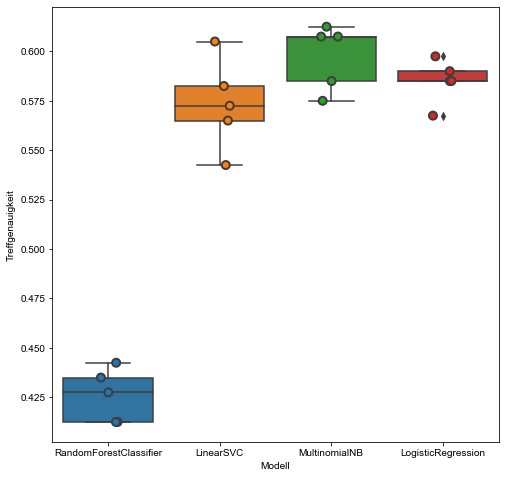

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

models = [
RandomForestClassifier(n_estimators=100),
LinearSVC(),
MultinomialNB(),
LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(8,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(rc={"figure.figsize":(3, 4)})
plt.xlabel('Modell')
plt.ylabel('Treffgenauigkeit')
plt.show()

In [5]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.5735
LogisticRegression        0.5850
MultinomialNB             0.5975
RandomForestClassifier    0.4260
Name: accuracy, dtype: float64

In [6]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.4125
1,RandomForestClassifier,1,0.4125
2,RandomForestClassifier,2,0.4425
3,RandomForestClassifier,3,0.4275
4,RandomForestClassifier,4,0.4350
5,LinearSVC,0,0.5650
6,LinearSVC,1,0.5425
7,LinearSVC,2,0.6050
8,LinearSVC,3,0.5825
9,LinearSVC,4,0.5725


In [7]:
from pandas.io.formats.style import Styler
print(pd.DataFrame(cv_df).style.to_latex(label='tab:table1', caption='Tabelle', clines='all;data'))

\begin{table}
\caption{Tabelle}
\label{tab:table1}
\begin{tabular}{llrr}
 & model_name & fold_idx & accuracy \\
0 & RandomForestClassifier & 0 & 0.412500 \\
\cline{1-4}
1 & RandomForestClassifier & 1 & 0.412500 \\
\cline{1-4}
2 & RandomForestClassifier & 2 & 0.442500 \\
\cline{1-4}
3 & RandomForestClassifier & 3 & 0.427500 \\
\cline{1-4}
4 & RandomForestClassifier & 4 & 0.435000 \\
\cline{1-4}
5 & LinearSVC & 0 & 0.565000 \\
\cline{1-4}
6 & LinearSVC & 1 & 0.542500 \\
\cline{1-4}
7 & LinearSVC & 2 & 0.605000 \\
\cline{1-4}
8 & LinearSVC & 3 & 0.582500 \\
\cline{1-4}
9 & LinearSVC & 4 & 0.572500 \\
\cline{1-4}
10 & MultinomialNB & 0 & 0.585000 \\
\cline{1-4}
11 & MultinomialNB & 1 & 0.575000 \\
\cline{1-4}
12 & MultinomialNB & 2 & 0.607500 \\
\cline{1-4}
13 & MultinomialNB & 3 & 0.607500 \\
\cline{1-4}
14 & MultinomialNB & 4 & 0.612500 \\
\cline{1-4}
15 & LogisticRegression & 0 & 0.585000 \\
\cline{1-4}
16 & LogisticRegression & 1 & 0.567500 \\
\cline{1-4}
17 & LogisticRegression & 2 & 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

entries = []
for model in models:
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test =train_test_split(features, labels, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    entries.append((model_name, matrix))

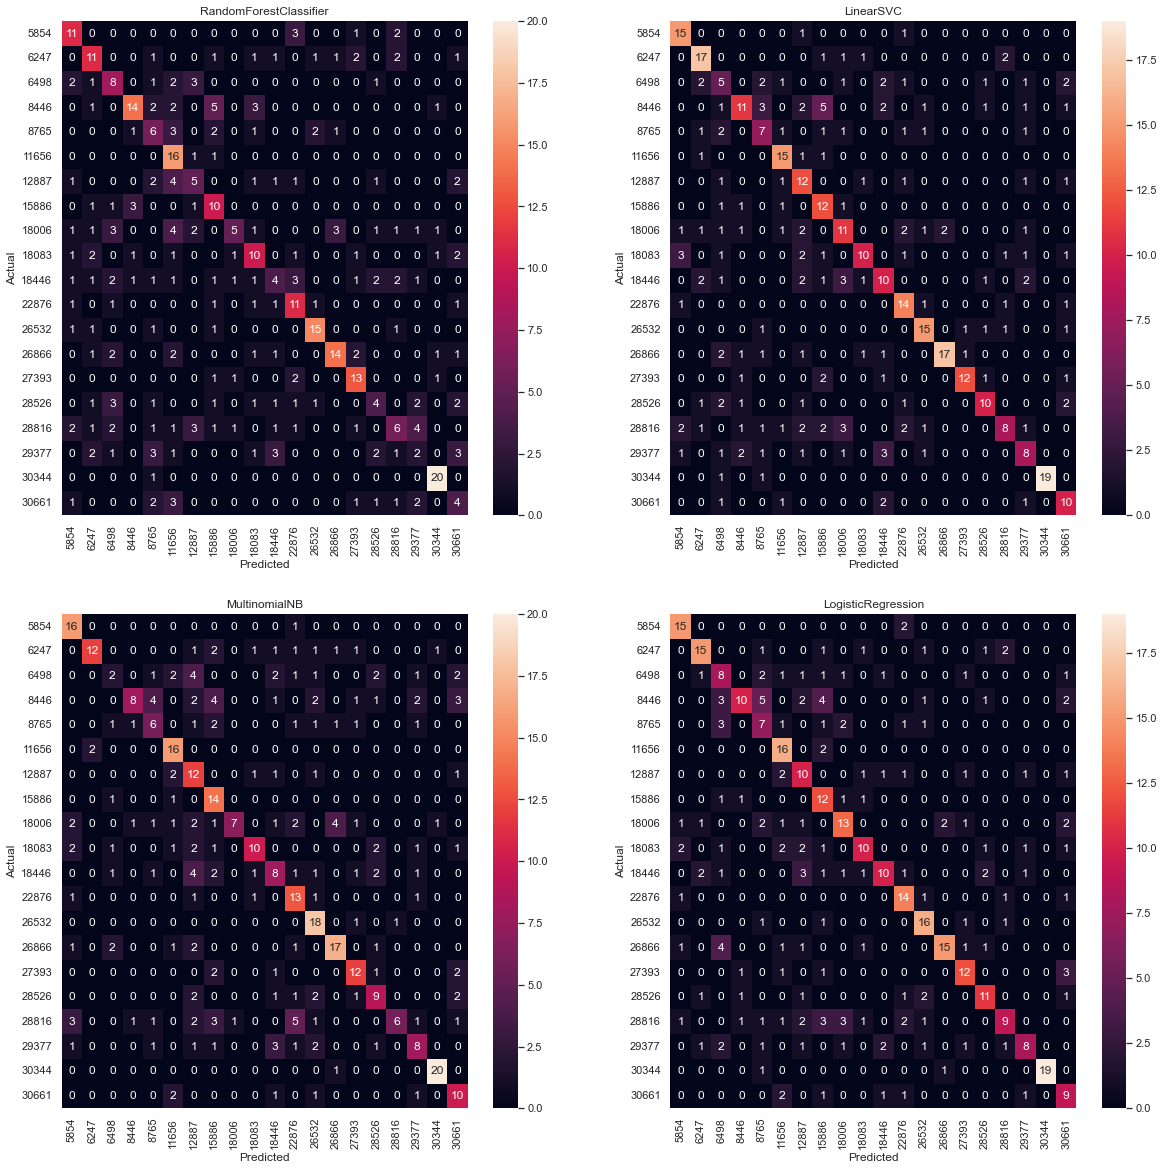

In [9]:
plt.figure(figsize=(20,20))
x = 1
for entry in entries:
    matrix = entry[1]
    plt.subplot(2,2,x)
    ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    
    ax.set(title=entry[0],
      xlabel="Predicted",
      ylabel="Actual",)
    x+=1
    
sns.set(font_scale=1)